# Tahap 4: Preprocessing Tanggal, EDA, dan Visualisasi

### Pastikan Anda sudah menginstal library yang dibutuhkan:
### pip install pandas matplotlib wordcloud

In [36]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --- 1. Membaca File Hasil Pelabelan ---
input_filepath = '../Data/hasil_pelabelan_transjakarta.csv' 
try:
    df = pd.read_csv(input_filepath)
    print(f"File '{input_filepath}' berhasil dibaca. Jumlah data: {len(df)} baris.")
except FileNotFoundError:
    print(f"Error: File '{input_filepath}' tidak ditemukan.")
    exit()

File '../Data/hasil_pelabelan_transjakarta.csv' berhasil dibaca. Jumlah data: 150 baris.


In [37]:
# --- 2. Preprocessing Kolom Tanggal ---
print("\nMemulai preprocessing tanggal...")

month_map = {
    'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'mei': '05', 'jun': '06',
    'jul': '07', 'agu': '08', 'sep': '09', 'okt': '10', 'nov': '11', 'des': '12'
}

def convert_date_final(date_str):
    if not isinstance(date_str, str):
        return None
    
    date_str = date_str.lower().strip()
    
    # Mencocokkan format HARI/BULAN/TAHUN
    # Regex ini akan mencari pola angka, pemisah, lalu angka/bulan, pemisah, dan tahun
    match = re.search(r'(\d{1,2})[\s/]+([a-z]{3,}|\d{1,2})[\s/]*(\d{2,4})?', date_str)
    
    if match:
        day, month_part, year = match.groups()
        
        # Konversi bulan dari nama ke angka jika perlu
        if month_part.isalpha():
            month = month_map.get(month_part[:3], '01')
        else:
            month = month_part
            
        # Standarisasi tahun (tambahkan '20' jika hanya 2 digit)
        if year:
            year = '20' + year if len(year) == 2 else year
        else:
            # Asumsi tahun 2025 jika tidak ada
            year = '2025'
            
        return f"{year}-{str(month).zfill(2)}-{str(day).zfill(2)}"

    return None

df['Tanggal_Format'] = df['Tanggal'].apply(convert_date_final)
df['Tanggal_Format'] = pd.to_datetime(df['Tanggal_Format'], errors='coerce')
df.dropna(subset=['Tanggal_Format'], inplace=True)

print("Preprocessing tanggal selesai.")
print("Contoh hasil konversi tanggal:")
print(df[['Tanggal', 'Tanggal_Format']].head())


Memulai preprocessing tanggal...
Preprocessing tanggal selesai.
Contoh hasil konversi tanggal:
   Tanggal Tanggal_Format
0  16/9/25     2025-09-16
1  29/8/25     2025-08-29
2  12/9/25     2025-09-12
3  19/7/25     2025-07-19
4  24/9/25     2025-09-24



Membuat visualisasi Distribusi Sentimen...


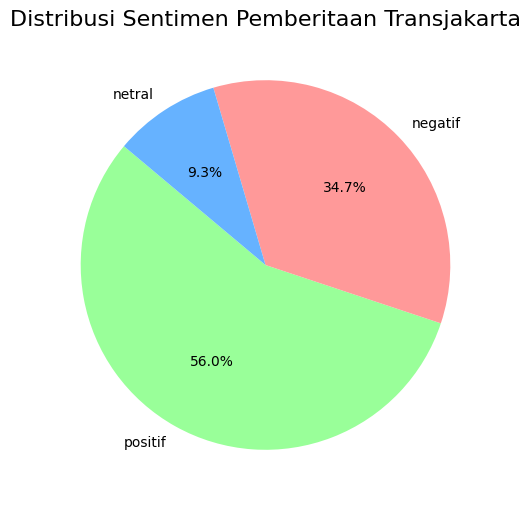

In [38]:
# --- 3. Visualisasi Distribusi Sentimen ---
print("\nMembuat visualisasi Distribusi Sentimen...")
plt.figure(figsize=(8, 6))
sentiment_counts = df['Sentimen'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#99FF99','#FF9999', '#66B2FF'])
plt.title('Distribusi Sentimen Pemberitaan Transjakarta', fontsize=16)
plt.ylabel('')
plt.show()

Membuat visualisasi Word Cloud...


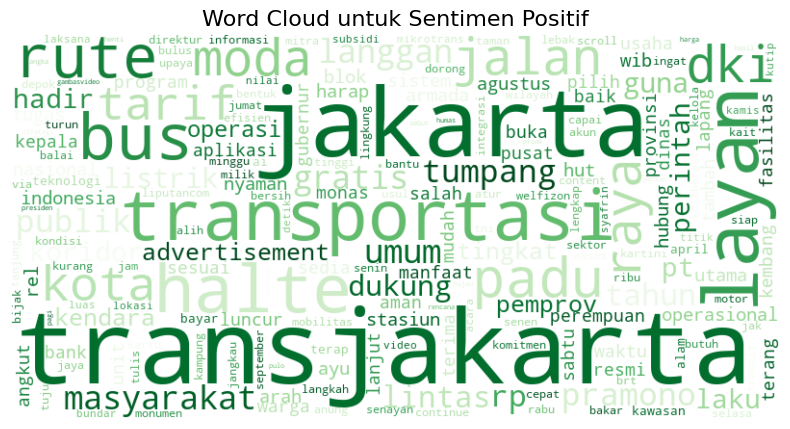

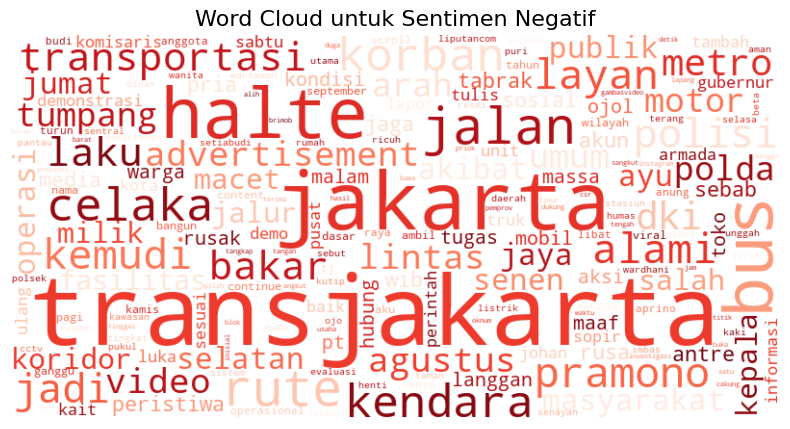

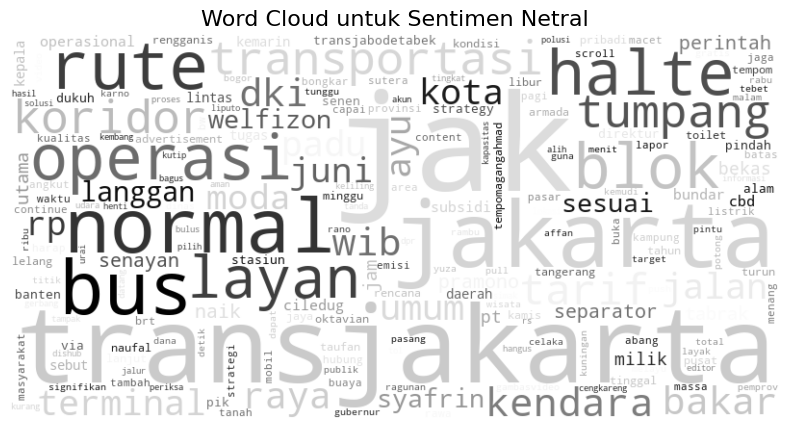

In [39]:
# --- 4. Visualisasi Word Cloud per Sentimen ---
print("Membuat visualisasi Word Cloud...")
sentiments = ['positif', 'negatif', 'netral']
color_maps = {
    'positif': 'Greens',
    'negatif': 'Reds',
    'netral': 'Greys'
}

for sentiment in sentiments:
    text = ' '.join(df[df['Sentimen'] == sentiment]['Teks_Stemmed'].dropna())
    
    if text:
        # Tambahkan parameter colormap di sini
        wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False, colormap=color_maps[sentiment]).generate(text)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud untuk Sentimen {sentiment.capitalize()}', fontsize=16)
        plt.axis('off')
        plt.show()

Membuat visualisasi Frekuensi Kata...


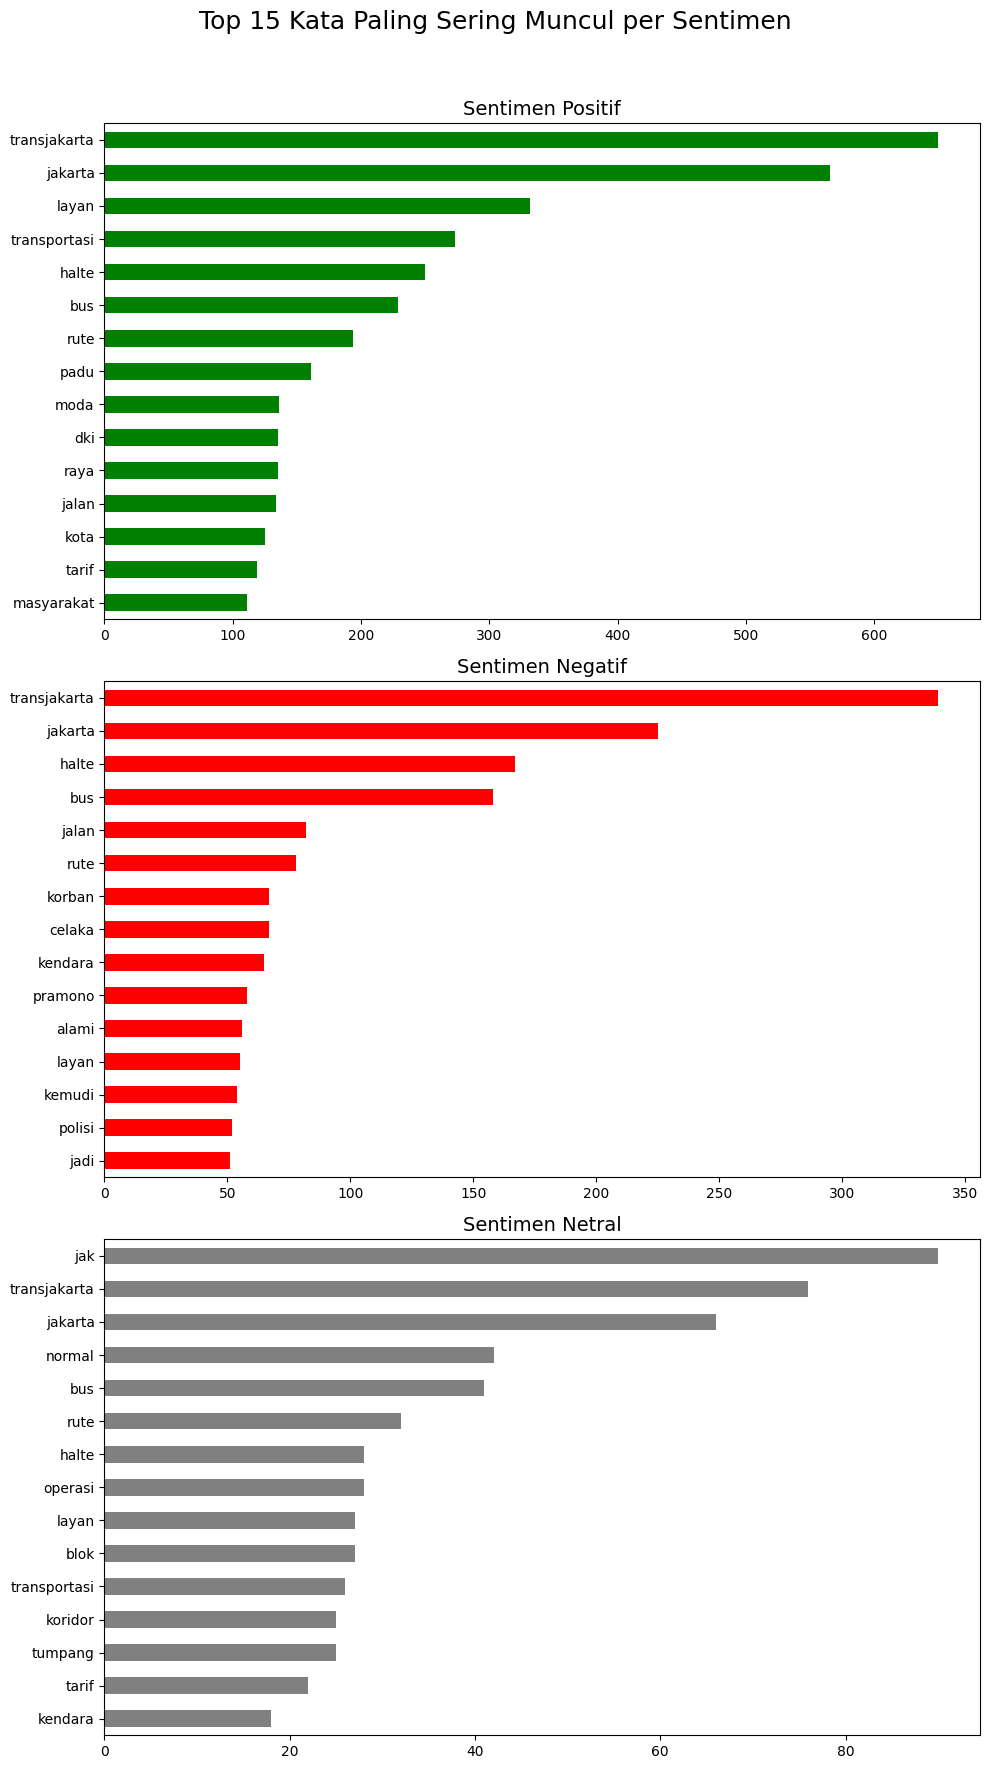

In [40]:
# --- 5. Visualisasi Frekuensi Kata per Sentimen ---
print("Membuat visualisasi Frekuensi Kata...")
fig, axes = plt.subplots(3, 1, figsize=(10, 18))
fig.suptitle('Top 15 Kata Paling Sering Muncul per Sentimen', fontsize=18)

colors = {'positif': 'green', 'negatif': 'red', 'netral': 'grey'}
for i, sentiment in enumerate(sentiments):
    corpus = ' '.join(df[df['Sentimen'] == sentiment]['Teks_Stemmed'].dropna())
    words = corpus.split()
    word_freq = pd.Series(words).value_counts().head(15)
    
    ax = axes[i]
    word_freq.sort_values().plot(kind='barh', ax=ax, color=colors[sentiment])
    ax.set_title(f'Sentimen {sentiment.capitalize()}', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Membuat visualisasi Tren Sentimen per Bulan...


C:\Users\Wede\AppData\Local\Temp\ipykernel_10632\3181017650.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_over_time = df_time_analysis.groupby([pd.Grouper(freq='M'), 'Sentimen']).size().unstack(fill_value=0)


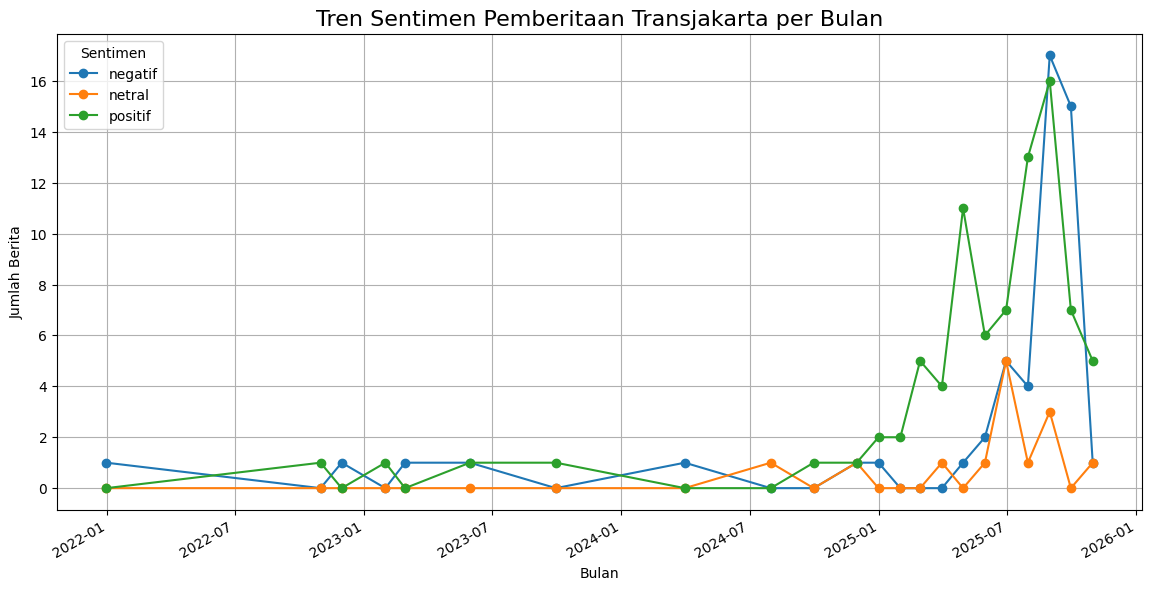

In [41]:
# --- 6. Analisis Sentimen Berdasarkan Waktu ---
print("Membuat visualisasi Tren Sentimen per Bulan...")
# Salin dataframe untuk menghindari SettingWithCopyWarning
df_time_analysis = df.copy()
df_time_analysis.set_index('Tanggal_Format', inplace=True)
# Kelompokkan data per bulan dan hitung jumlah sentimen
sentiment_over_time = df_time_analysis.groupby([pd.Grouper(freq='M'), 'Sentimen']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
ax = plt.gca()
sentiment_over_time.plot(kind='line', marker='o', ax=ax)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Tren Sentimen Pemberitaan Transjakarta per Bulan', fontsize=16)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Berita')
plt.grid(True)
plt.legend(title='Sentimen')
plt.show()

In [42]:
# Simpan hasil akhir ke file CSV baru
output_filepath = '../Data/hasil_final_analisis_transjakarta.csv'
df.to_csv(output_filepath, index=False, encoding='utf-8')
print(f"\n✅ Proses selesai. Data dengan tanggal terformat disimpan di: {output_filepath}")


✅ Proses selesai. Data dengan tanggal terformat disimpan di: ../Data/hasil_final_analisis_transjakarta.csv
